# Predicting response times of the Paris Fire Brigade vehicles

# Presentation of the background

This data subject is extracted from a list of challenges proposed by the ENS.

The goal is to be able to predict the response time of the fire brigade of Paris. With this information the fire brigade can choose better wich vehicle to select and where in order to optimize their response time which could save lives.<br>
The goal is then to predict which vehicle to choose and how long it will last to arrive on site.

# Data presentation

The data is composed of a training set and a testing set. However the testing set output is not available since it is used for evaluating the score of the ML algorithm on the ENS platform.

A detailed presentation of the data is available here https://paris-fire-brigade.github.io/data-challenge/challenge.html

The output has four components: <br>
- The ID of the choosen vehicle <br>
- The time between selection of the vehicle and the departure <br>
- The time between departure of the vehicle and the arrival on site <br>
- The time between selection of the vehicle and the arrivel on site (sum of the first two)

To predict those outputs we have a very detailed data set at hand. I will not go through each columns in this notebook but we can divide those columns into four categories: <br>
- The continuous variables, which can be used for regression <br>
- The categorical variables, which can be used for classification <br>
- The labels variables, which are not really useful and are often associated to a categorical variable <br>
- Other types of variables that cannot be directly used (such as latitude and longitude and others...)

There are also some supplementary files that can be used in the study but I will not go through this since they are more complicated to use. Maybe at the end to enhance the model.

# Data exploration

In this section I will have a look at what the data looks like, I will also look briefly at the influence of the input variables on the ouput to better understand the data set.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Data reading
X = pd.read_csv('C:/Users/vinch/Dropbox/Centrale Lyon 2A/S8/Machine Learning/Projet pompiers/x_train.csv', sep=',')
y = pd.read_csv('C:/Users/vinch/Dropbox/Centrale Lyon 2A/S8/Machine Learning/Projet pompiers/y_train.csv', sep=',')
#X_test = pd.read_csv('C:/Users/vinch/Dropbox/Centrale Lyon 2A/S8/Machine Learning/Projet pompiers/x_test.csv', sep=',')

### Continuous variables

Let's look at someting basic. I'm going to plot the transit time as a function of the estimated travel distance.

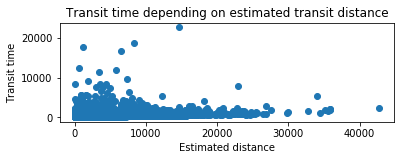

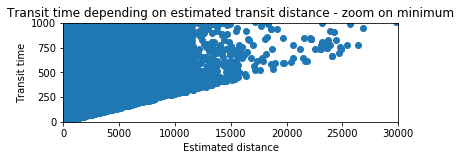

In [2]:
X_est_dist = X[['OSRM estimated distance']]
y_transit_time = y[['delta departure-presentation']]
%matplotlib inline
plt.subplot(211)
plt.plot(X_est_dist,y_transit_time,'o')
plt.xlabel("Estimated distance")
plt.ylabel("Transit time")
plt.title("Transit time depending on estimated transit distance")
plt.show()
plt.subplot(212)
plt.plot(X_est_dist,y_transit_time,'o')
plt.xlabel("Estimated distance")
plt.ylabel("Transit time")
plt.title("Transit time depending on estimated transit distance - zoom on minimum")
plt.xlim(0, 30000)
plt.ylim(0, 1000)
plt.show()

What we can see here is, first, many outliers on short distances, probably due to traffic jam in the city. But most importantly we see that the minimum of the transit time follows a linear relation with the estimated distance.

Let's plot the same graph but with the departure time.

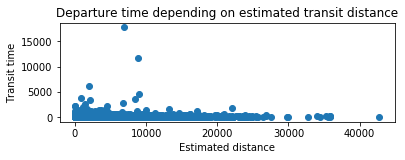

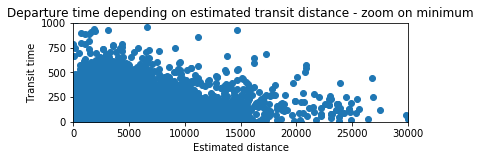

In [3]:
X_est_dist = X[['OSRM estimated distance']]
y_dep_time = y[['delta selection-departure']]
%matplotlib inline
plt.subplot(211)
plt.plot(X_est_dist,y_dep_time,'o')
plt.xlabel("Estimated distance")
plt.ylabel("Transit time")
plt.title("Departure time depending on estimated transit distance")
plt.show()
plt.subplot(212)
plt.plot(X_est_dist,y_dep_time,'o')
plt.xlabel("Estimated distance")
plt.ylabel("Transit time")
plt.title("Departure time depending on estimated transit distance - zoom on minimum")
plt.xlim(0, 30000)
plt.ylim(0, 1000)
plt.show()

The correlation between this two variables is very unclear, we can even assume that the slight decrease in departure time is due to the fact that there is more data for short distances than for long distances.

### Categorical variables

Let's now have a how on what categorical variables influence the output. I will plot the departure time depending on the alert reason.

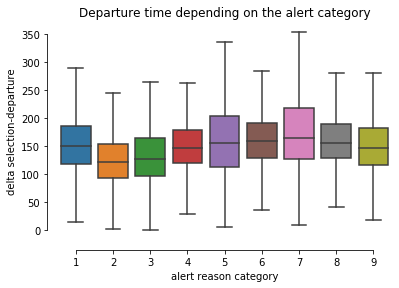

In [4]:
X_alert_reason = X[['alert reason category']]
y_dep_time = y[['delta selection-departure']]

# Draw a nested boxplot to show bills by day and time

sns.boxplot(x=X_alert_reason['alert reason category'], y=y_dep_time['delta selection-departure'],showfliers = False).set_title("Departure time depending on the alert category")
sns.despine(offset=10, trim=True)

The category of the emergency seems to influence how fast do the fire brigade respond hence the need to include this type of data in our analysis. <br> <br>
Let's plot the same graph but with the transit time.

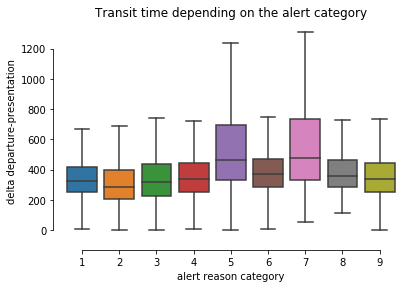

In [5]:
y_trans_time = y[['delta departure-presentation']]

sns.boxplot(x=X_alert_reason['alert reason category'], y=y_trans_time['delta departure-presentation'],showfliers = False).set_title("Transit time depending on the alert category")
sns.despine(offset=10, trim=True)

The influence is different, there really seem to be two types of alerts. One way to interpret this is to say that some alerts are categorized as urgents and thus justifie the use of sirens and other methods to arrive faster to the intervention site. Others (5 and 7) don't and arrive later at the intervention site.

Let's have a look also at the influence of the hour on the transit time:

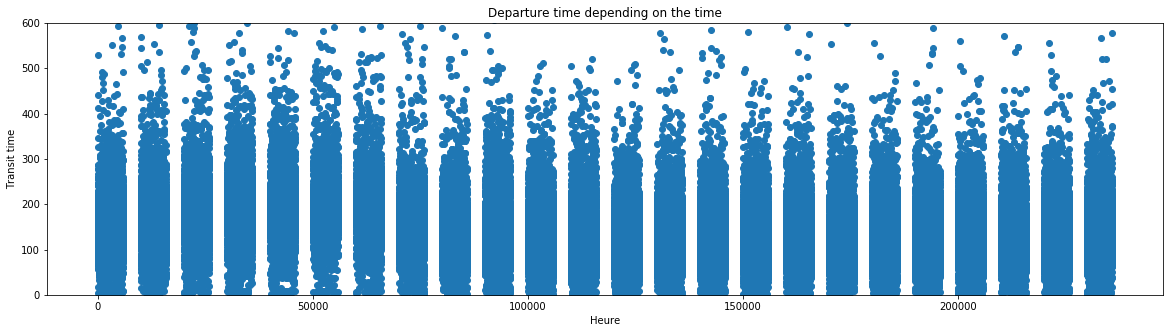

In [6]:
X_est_dist = X[['time key sélection']]
y_dep_time = y[['delta selection-departure']]
%matplotlib inline
plt.figure(figsize=(20,5))
plt.plot(X_est_dist,y_dep_time,'o')
plt.xlabel("Heure")
plt.ylabel("Transit time")
plt.title("Departure time depending on the time")
plt.ylim(0,600)

plt.show()


### Conclusion of this section

The variables are diverse and have different types of influence on the output. In this section we've seen only the influence of two variables but these examples show that variables can have an effect on both of the times to predict. But they can also have no effects at all on one of the times. We will then need to choose which variables to use to predict each of the times.

# Methodology

The objective is to predict the time of response of the fire brigade. This response time is divided into two different times: the departure time ("delta selection-departure" time between the selection of the vehicle and the departure of the vehicle) and the transit time ("delta departure-presentation" time between departure and arrival on site).<br>
Those two times are different and should each have their own approach. For example we've seen that the estimated distance travel did not influence the departure time whereas the alert category influenced both times.<br>
Therefore in a first time we'll try to predict the departure time. Then we'll try to predict the transit time.

## Departure time

So now let's focus on predicting the departure time. To do this we first have to select which features we are going to keep, then which model/techniques we are going to use to predict the departure time.

### Feature selection

What we're going to do here is plot the evolution of the departure time of all the features to determine which ones we are going to keep. But first let's make a selection because not all the features are exploitable. They could be but that would require a preprocessing, we'll keep those features for a later enhancing.

In [7]:
selected_categories = ['alert reason category',
                    'intervention on public roads',
                    'floor',
                    'location of the event',
                    'emergency vehicle type',
                    'rescue center',
                    'status preceding selection',
                    'departed from its rescue center']

selected_variables = ['OSRM estimated distance',
                     'OSRM estimated duration',
                     'delta status preceding selection-selection']

y_dep_time = y[['delta selection-departure']]

alert reason category


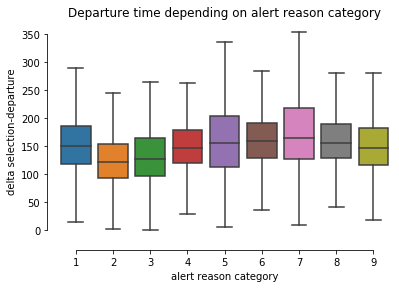

intervention on public roads


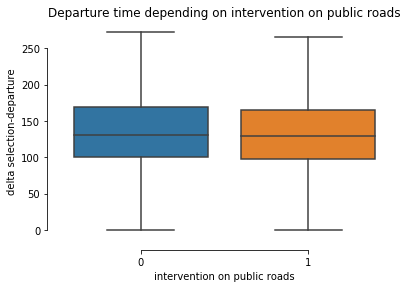

floor


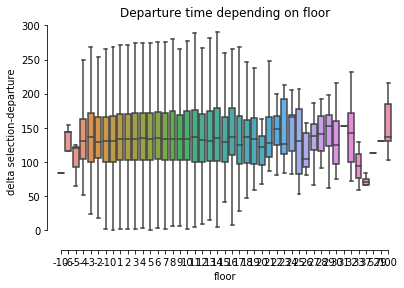

location of the event


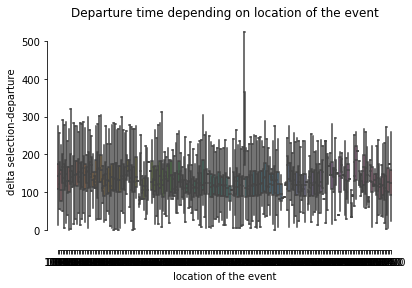

emergency vehicle type


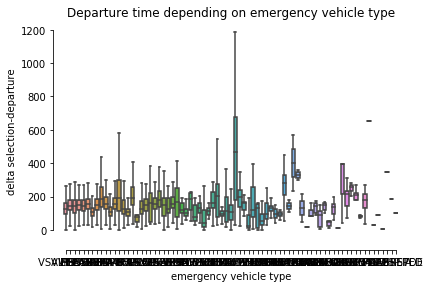

rescue center


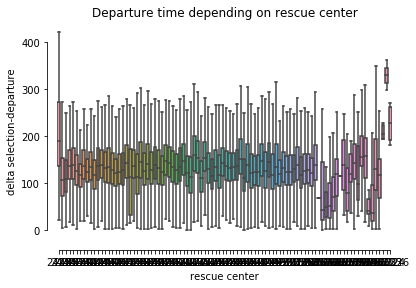

status preceding selection


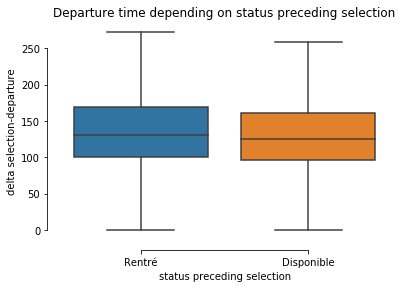

departed from its rescue center


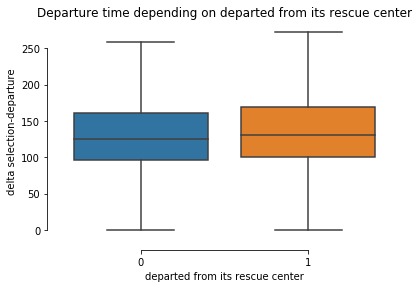

OSRM estimated distance


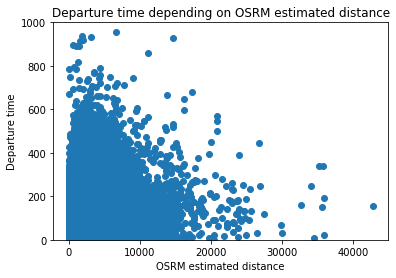

OSRM estimated duration


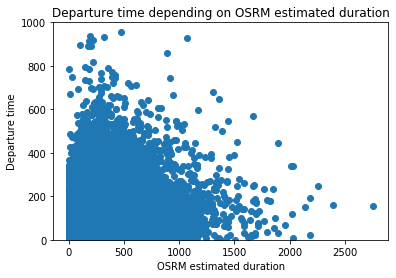

delta status preceding selection-selection


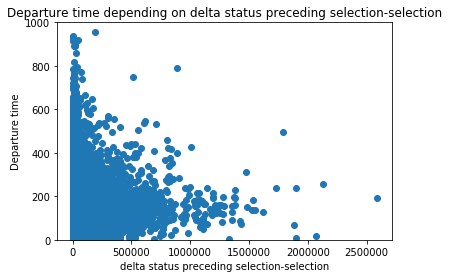

In [8]:
for categ in selected_categories:
    print(categ)
    X_temp = X[[categ]]
    sns.boxplot(x=X_temp[categ], y=y_dep_time['delta selection-departure'],showfliers = False).set_title("Departure time depending on " + categ)
    sns.despine(offset=10, trim=True)
    plt.show()

for var in selected_variables:
    print(var)
    X_temp = X[[var]]
    plt.plot(X_temp,y_dep_time,'o')
    plt.xlabel(var)
    plt.ylabel("Departure time")
    plt.title("Departure time depending on " + var)
    plt.ylim(0,1000)
    plt.show()

After analysis we only keep categories for determing the departure time. This is good news. The bad news is for some of the categories there are up to 211 categories, we may remove them in the future...

# Modeling

Here a function meant to reorder the categories so they are easier to model in linear regression and a function modyfing the date and time so that thet can be used.

In [2]:
def reorder_categ(df,categ_to_order,order_by):
    averages = df.groupby(categ_to_order).median()[order_by]
    serie_sort = averages.sort_values()
    keys = serie_sort.index.tolist()
    values = [i+1 for i in range(len(keys))]
    
    sort_dict = dict()
    for i in range(len(keys)):
        sort_dict[keys[i]] = values[i]
        
    df[categ_to_order] = df[categ_to_order].astype('category').cat.rename_categories(sort_dict)
    sns.boxplot(x=df[categ_to_order], y=df[order_by],showfliers = False, order=values).set_title("Departure time depending on " + categ_to_order)
    sns.despine(offset=10, trim=True)
    plt.show()
    return df

def modify(data):
    	# Only use the month of the date
        data['date key sélection'] = data['date key sélection'].apply(
            lambda x: int(str(x)[4:6]))
        data['time key sélection'] = data['time key sélection'].apply(
            lambda x: int(str(x)[:2]))

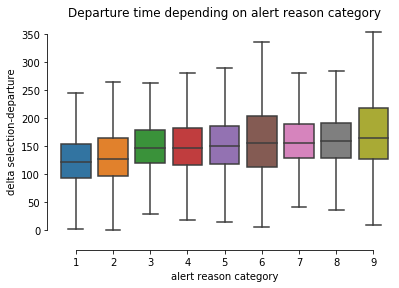

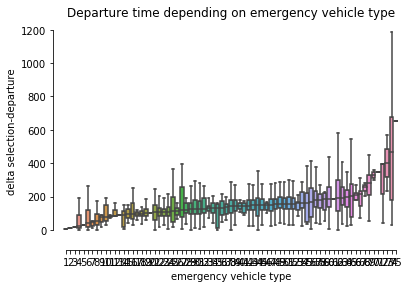

C:\Users\vinch\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\vinch\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
from sklearn.model_selection import train_test_split

x_train = X
y_train = y
x_train['delta selection-departure'] = y_train['delta selection-departure']
    
x_train = reorder_categ(x_train,'alert reason category','delta selection-departure')
x_train = reorder_categ(x_train,'emergency vehicle type','delta selection-departure')

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33)

modify(x_train)
modify(x_test)

params1 = ['alert reason category', 'time key sélection',
           'date key sélection', 'emergency vehicle type']
params2 = ['OSRM estimated distance', 'OSRM estimated duration',
           'intervention on public roads', 'floor']

x_train_1 = x_train[params1]
x_test_1 = x_test[params1]
y_train_1 = y_train[['delta selection-departure']]

x_train_2 = x_train[params2]
x_test_2 = x_test[params2]
y_train_2 = y_train[['delta departure-presentation']]

### Using linear regression

In [4]:
polynomial_features_1 = PolynomialFeatures(degree=3)
x_train_1 = polynomial_features_1.fit_transform(x_train_1)
model_1 = LinearRegression()
model_1.fit(x_train_1, y_train_1)

polynomial_features_2 = PolynomialFeatures(degree=3)
x_train_2 = polynomial_features_2.fit_transform(x_train_2)
model_2 = LinearRegression()
model_2.fit(x_train_2, y_train_2)

# Prediction
x_test_1 = polynomial_features_1.fit_transform(x_test_1)
y_test_1 = model_1.predict(x_test_1)
x_test_2 = polynomial_features_2.fit_transform(x_test_2)
y_test_2 = model_2.predict(x_test_2)

In [5]:
from sklearn.metrics import r2_score
submission = pd.concat([pd.DataFrame(x_test[['emergency vehicle selection']].values),
                        pd.DataFrame(y_test_1),
                        pd.DataFrame(y_test_2),
                        pd.DataFrame(y_test_1 + y_test_2)],
                        axis=1)
print(r2_score(y_test, submission))

0.3810760234104162


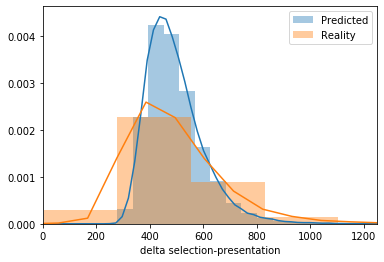

In [17]:
sns.distplot(y_test_1 + y_test_2,label="Predicted")
sns.distplot(y_test['delta selection-presentation'],label="Reality")

plt.xlim(0,1250)
plt.legend()

In [36]:
def mean_abs_error(y,ypred):
    y = np.array(y)
    ypred = np.array(ypred)
    print(y)
    print(ypred)
    N = len(y)
    somme = 0
    avg = 0
    for i in range(len(y)):
        somme += abs(y[i]-ypred[i][0])
    for i in range(len(y)):
        avg += y[i]
    avg = avg/N
    return somme/N, avg

In [37]:
mae, avg = mean_abs_error(y_test['delta selection-presentation'],y_test_1 + y_test_2)

[355 482 575 ... 457 300 411]
[[421.26665238]
 [715.08123062]
 [639.65344013]
 ...
 [490.61766244]
 [391.23314918]
 [400.03019766]]


In [38]:
mae

114.10788167674862

In [39]:
avg

494.8974192478793

In [40]:
mae/avg

0.23056875473338323